In [1]:
# import packages 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn

from tqdm import tqdm

In [2]:
# load data 
def get_data(target):
    df = pd.read_csv('./scraped_data/elo_pfr_betting_data.csv', low_memory=False)
    
    # Prediction O/U
    if(target == 'ou_result'): # Classification
        df['OU_RESULT'] = df['ou_result'].apply(lambda x: 0 if(x == 'U') else 1 if(x == 'O') else 2)
        task = 'classification'
    if(target == 'ou_line'): # Regression
        df['OU_RESULT'] = df['ou_result'].apply(lambda x: 0 if(x == 'U') else 1 if(x == 'O') else 2)
        df['OU_LINE'] = df['ou_line']
        task = 'regression'
        
    if('ou' in target):
        df = df.dropna(subset=[target])
        df = df[df['OU_RESULT'] != 2]
        
    if(target == 'spread_result'): # Classification
        df['SPREAD_RESULT'] = df['spread_result'].apply(lambda x: 0 if(x == 'L') else 1 if(x == 'W') else 2)
        task = 'classification'
    if(target == 'spread'): # Regression
        df['SPREAD_RESULT'] = df['spread_result'].apply(lambda x: 0 if(x == 'L') else 1 if(x == 'W') else 2)
        df['SPREAD'] = df['spread']
        task = 'regression'

    if('spread' in target):
        df = df.dropna(subset=[target])
        df = df[df['SPREAD_RESULT'] != 2]
    
    return df, target.upper(), task


In [3]:
def get_columns(df, target):
    game_data_columns = []
    for c in df.columns:
        if("home" in c or "away" in c):
            if('td' not in c and 'xp' not in c and 'fg' not in c and 'poss' not in c and 'down' not in c and target not in c):
                game_data_columns.append(c)

    return df[game_data_columns]

In [69]:
# Create a dataset that pytorch loader can work with 
class NFLClassificationDataset(Dataset):
    def __init__(self, dataframe, target, features, task='classification'):
        self.features = features
        self.target = target
        if(task == 'classification'):
            self.y = torch.tensor(dataframe[target].values).long()
        else:
            self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [223]:
def split_data(df, target, task, year=2020):
    '''
        Uses single year as validaion year. Previous years are train, future years are test
    '''
    df_train = benchmark_data[df['year'] <= year].copy()
    df_val = benchmark_data[df['year'] == year].copy()
    df_test = benchmark_data[df['year'] > year].copy()

    for c in df_train.columns:
        if(task == 'classification' and c == target):
            continue
        mean = df_train[c].mean()
        stdev = df_train[c].std()

        df_train[c] = (df_train[c] - mean) / stdev
        df_val[c] = (df_val[c] - mean) / stdev
        df_test[c] = (df_test[c] - mean) / stdev

    df_train[target] = df[df['year'] < year][target]
    df_val[target] = df[df['year'] == year][target]
    df_test[target] = df[df['year'] > year][target]
    
    df_train = df_train.dropna(subset=[target])
    df_val = df_val.dropna(subset=[target])
    df_test = df_test.dropna(subset=[target])
    
    return df_train, df_val, df_test

def get_data_loaders(df_train, df_val, df_test, task, batch_size=32):
    features = list(df_train.columns.difference([target]))
    train_dataset = NFLClassificationDataset(df_train, target=target, features=features, task=task)
    val_dataset = NFLClassificationDataset(df_val, target=target, features=features, task=task)
    test_dataset = NFLClassificationDataset(df_test, target=target, features=features, task=task)
    
    # Set the dataset in pytorch dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader

In [227]:
# Training 
def train(data, model, loss_func, optimizer, task):
    n_batches = len(data)
    total_loss = 0
    model.train()
    
    for x,y in data:
        output= model(x)
        if(task=='classification'):
            loss = loss_func(output, y)
        if(task=='regression'):
            loss = loss_func(output, y[:,np.newaxis])
            #print(loss)
            #raise
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    mean_loss = total_loss/n_batches
    return mean_loss, model
    

def test(data, model, loss_func, task):
    n_batches = len(data)
    total_loss = 0
    
    model.eval()
    with torch.no_grad():
        for x, y in data:
            output = model(x)
            if(task == 'classification'):
                total_loss += loss_func(output,y).item()
            else:
                total_loss += loss_func(output,y[:,np.newaxis]).item()
            
    mean_loss = total_loss/n_batches
    
    return mean_loss   

# prediction function
def predict(data, model):
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X,_ in data:
            y_fit = model(X)
            output = torch.cat((output,y_fit), 0)
    return output

In [236]:
def evaluate(data, model):
    preds, labels = torch.Tensor([]), torch.Tensor([])
    with torch.no_grad():
        for x, y in data:
            labels = torch.cat((labels, y))
            preds = torch.cat((preds, torch.argmax(model(x[np.newaxis]), dim=2)[0]))            
            
    acc = 100*sum(np.array(preds) == np.array(labels))/len(preds)
    print("CLASSIFICATION ACCURACY: {0:.3f}%".format(acc))
    return acc

def classification_betting_result(model, test_loader, threshold=0.6):
    print("THRESHOLD: {}".format(threshold))
    with torch.no_grad():
        good_bet = 0
        bad_bet = 0
        money = 0
        total_games = 0
        for x, y in test_loader:
            pred = model(x)
            pred_label = torch.argmax(model(x), dim=1)
            for i in range(len(pred)):
                print(pred)
                if(pred[i][pred_label[i]] > threshold):
                    if(pred_label[i] == y[i]):
                        good_bet += 1
                        money += 90.91
                    else:
                        bad_bet += 1
                        money -= 100
                total_games += 1

    print("GOOD BETS: {}\tBAD BETS: {}".format(good_bet, bad_bet))
    print("MONEY MADE: {0:.2f} BETTING ON {1:.2f}% OF GAMES".format(money, 100*(bad_bet+good_bet)/total_games))
    return money, (bad_bet+good_bet)/total_games


def regression_betting_result(model, test_loader, threshold=0.6):
    print("THRESHOLD: {}".format(threshold))
    with torch.no_grad():
        good_bet = 0
        bad_bet = 0
        money = 0
        total_games = 0
        for x, y in test_loader:
            pred = model(x)
            print(pred)
            print(y)
            pred_label = torch.argmax(model(x), dim=1)
            for i in range(len(pred)):
                if(pred[i][pred_label[i]] > threshold):
                    if(pred_label[i] == y[i]):
                        good_bet += 1
                        money += 90.91
                    else:
                        bad_bet += 1
                        money -= 100
                total_games += 1
                raise

    print("GOOD BETS: {}\tBAD BETS: {}".format(good_bet, bad_bet))
    print("MONEY MADE: {0:.2f} BETTING ON {1:.2f}% OF GAMES".format(money, 100*(bad_bet+good_bet)/total_games))
    return money, (bad_bet+good_bet)/total_games

## Put it all together

363 8 10


100%|██████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


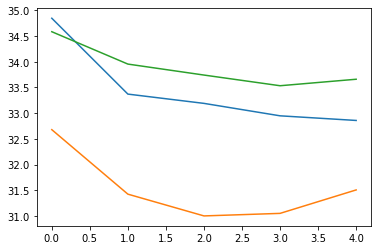

THRESHOLD: 0.1
tensor([[-0.4981],
        [ 3.1184],
        [-0.3004],
        [ 3.6700],
        [-5.1638],
        [-1.5577],
        [-1.3147],
        [-1.0225],
        [-3.8000],
        [-1.1375],
        [-4.4415],
        [-2.3748],
        [-6.1697],
        [ 2.4512],
        [ 0.2935],
        [-5.0148],
        [-4.9308],
        [-0.6704],
        [-3.2792],
        [-2.9685],
        [-5.0908],
        [-3.7495],
        [-1.3230],
        [-4.0251],
        [ 0.4412],
        [-1.5056],
        [-1.7734],
        [-4.1174],
        [-1.4115],
        [-1.4374],
        [-3.0612],
        [-1.9150]])
tensor([  3.5000,   6.0000,  -6.5000,   9.5000,  -3.5000,  -7.5000,  -1.0000,
         -4.5000,  -7.0000,  -7.5000,  -3.0000, -11.0000,   1.0000,   5.5000,
          6.5000, -10.0000, -13.0000,   2.5000,  -4.5000,   3.0000,  -8.0000,
          3.0000,   9.0000,  -3.0000,   6.0000, -11.0000,   4.5000,  -6.5000,
          7.0000,   2.5000,  -2.5000,  -1.0000])


RuntimeError: No active exception to reraise

In [237]:
# Get data    
target = 'spread'
df, target, task = get_data(target)
benchmark_data = get_columns(df, target)

df_train, df_val, df_test = split_data(df, target, task)
df_train = df_train.dropna()

train_loader, val_loader, test_loader = get_data_loaders(df_train, df_val, df_test, task, batch_size=32)

thresholds = np.linspace(0.5, 1.0, 51)
money_made = []
games_bet = []
# hyperparameters
lr = 1e-3
epoch = 5
input_size = len(list(df_train.columns.difference([target])))
hidden_size = 64
dropout = 0.2

if(task == 'classification'):
    model = nn.Sequential(
        nn.Linear(input_size, 64),
        nn.Dropout(dropout),
        nn.ReLU(),
        nn.Linear(64,64),
        nn.Dropout(dropout),
        nn.ReLU(),
        nn.Linear(64,2),
        nn.Softmax(dim=1)
    )
    loss_func = nn.CrossEntropyLoss()
elif(task == 'regression'):
    model = nn.Sequential(
        nn.Linear(input_size, 64),
        nn.Dropout(dropout),
        nn.ReLU(),
        nn.Linear(64,64),
        nn.Dropout(dropout),
        nn.ReLU(),
        nn.Linear(64,1),
    )
    loss_func = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Run lstm 
trainloss = []
testloss = []
valloss = []
print(len(train_loader), len(val_loader), len(test_loader))
for i in tqdm(range(epoch)):
    train_loss, model = train(train_loader, model, loss_func, optimizer=optimizer, task=task)
    trainloss.append(train_loss)

    val_loss = test(val_loader, model, loss_func, task=task)
    valloss.append(val_loss)

    test_loss  = test(test_loader, model, loss_func, task=task)
    testloss.append(test_loss)    

fig, ax = plt.subplots()
ax.plot(trainloss)
ax.plot(valloss)
ax.plot(testloss)
plt.show()

if(task == 'classification'):
    val_accuracy = evaluate(val_loader, model)
    test_accuracy = evaluate(test_loader, model)
    result = classification_betting_result(model, val_loader, threshold=0.7)
    money_made.append(result[0])
    games_bet.append(result[1])
elif(task == 'regression'):
    result = regression_betting_result(model, val_loader, threshold=0.1)
    money_made.append(result[0])
    games_bet.append(result[1])
        
fig, ax = plt.subplots(ncols=2, figsize=(15,6))
ax[0].plot(thresholds, money_made)
ax[1].plot(thresholds, games_bet)
plt.show()

### Bayesopt

In [ ]:
def get_datasets(batch_size=16):
    
    # Get dataset
    test_start = int(df.shape[0]*0.8)
    valid_start = int(df.shape[0]*0.64)
    df_train = benchmark_data.loc[:valid_start].copy()
    df_valid = benchmark_data.loc[valid_start:test_start].copy()
    df_test  = benchmark_data[test_start:].copy()
    
    # Standardize features 
    for c in df_train.columns:
        mean = df_train[c].mean()
        stdev = df_train[c].std()

        df_train[c] = (df_train[c] - mean) / stdev
        df_valid[c] = (df_valid[c] - mean) / stdev
        df_test[c] = (df_test[c] - mean) / stdev
        
    df_train[target] = df.loc[:test_start][target]
    df_valid[target] = df.loc[valid_start:test_start][target]
    df_test[target] = df.loc[test_start:][target]
    
    features = list(df_train.columns.difference([target]))
    train_dataset = NFLClassificationDataset(df_train, target=target, features=features)
    valid_dataset = NFLClassificationDataset(df_valid, target=target, features=features)
    test_dataset = NFLClassificationDataset(df_test, target=target, features=features)
    
    #torch.manual_seed(99)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    return train_loader, valid_loader, test_loader

def get_model(lr, features, hidden_size, dropout, num_layers):
    # hyperparameters
    lr = lr
    input_size = len(features)
    hidden_size = hidden_size
    dropout = dropout
    num_layers = num_layers

    # Build model
    layers = [nn.Linear(input_size, hidden_size), nn.ReLU()]
    for l in range(num_layers):
        layers.append(nn.Linear(hidden_size, hidden_size))
        layers.append(nn.Dropout(dropout))
        layers.append(nn.ReLU())
    layers.append(nn.Linear(hidden_size, 2))
    layers.append(nn.Softmax(dim=1))
    
    model = nn.Sequential(*layers)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    return model, optimizer

def evaluate(data, model):
    preds, labels = [], []
    with torch.no_grad():
        for x, y in data:
            #print(x.shape)
            #print(y, model(x).argmax().item())
            labels.append(y.item())
            preds.append(model(x[np.newaxis]).argmax().item())
            
    #print(preds)
    acc = 100*sum(np.array(preds) == np.array(labels))/len(preds)
    print(sum(preds))
    print("CLASSIFICATION ACCURACY: {0:.3f}%".format(acc))
    return acc
            
evaluate(test_dataset, model)

In [ ]:
def target_function(lr=3, epoch=1000, hidden_size=32, num_layers=1, dropout=2., batch_size=16):
    train_loader, valid_loader, test_loader = get_datasets(batch_size=int(batch_size))
    model, optimizer = get_model(10**(-lr), features, int(hidden_size), 1/dropout, int(num_layers))
    loss_func = nn.CrossEntropyLoss()
    model.train()
    #print(model)
    #for p in model.parameters():
    #    print(p[0][:5])
    #    break
    
    # Run lstm 
    trainloss = []
    valloss = []
    for i in tqdm(range(int(epoch))):
        #for p in model.parameters():
        #    print(p[0][:5])
        #    break
        #train_loss, model = train(train_loader, model, loss_func, optimizer=criterion)
        total_loss = 0
        for bn, (x,y) in enumerate(train_loader):
            output = model(x)
            #print(output)
            loss = loss_func(output, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        train_loss = total_loss/(bn+1)
        
        trainloss.append(train_loss)
        val_loss  = test(valid_loader, model, loss_func)
        valloss.append(val_loss)

    return evaluate(valid_loader.dataset, model)

target_function(batch_size=32, lr=4, hidden_size=64, epoch=10)

In [ ]:
from bayes_opt import BayesianOptimization

pbounds = {
    'lr': (3,4),
    'epoch': (10, 20),
    'hidden_size': (32, 256),
    'num_layers': (3, 5),
    'dropout': (0., 10000.),
    'batch_size': (1, 128),
}

optimizer = BayesianOptimization(
    f=target_function,
    pbounds=pbounds,
    random_state=1
)

In [ ]:
optimizer.maximize(
    init_points=100,
)

In [ ]:
print(optimizer.max)